**Temat:** Analiza sentymentu w tekstach internetowych w oparciu o sieci typu Transformer

**Wprowadzenie:** Analiza sentymentu to technika przetwarzania języka naturalnego (NLP), która identyfikuje ton emocjonalny w tekście, klasyfikując go na pozytywny, negatywny lub neutralny. Wykorzystuje się ją do badania opinii klientów, monitorowania reputacji marki czy analizy treści mediów społecznościowych.

**Cel projektu:** Celem projektu jest opracowanie i implementacja modelu analizy sentymentu, który pozwoli na klasyfikację opinii użytkowników na podstawie tekstów pochodzących z Internetu. Należy przeanalizować dane tekstowe, przygotować odpowiedni model oraz zaprezentować wyniki analizy.

### Konfiguracja środowiska 

In [6]:
%pip install datasets transformers torch langdetect scikit-learn seaborn pandas matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


### Ładowanie danych

In [1]:
from datasets import load_dataset
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

/Users/mikolaj/Desktop/STUDIA/CDV STOPIEŃ II/I ROK/II SEMESTR/Uczenie głebokie w przetwarzaniu języka/PROJEKT/Multilingual-sentiment-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def is_target_language(text, target_lang):
    try:
        detected = detect(text)
        return detected == target_lang
    except LangDetectException:
        return False

def load_and_filter_dataset(languages, split, max_rows=20000, seed=42):
    train_ds = load_dataset("clapAI/MultiLingualSentiment", split=split)
    
    filtered_datasets = {}
    
    for lang in languages:
        # Filter by language
        lang_dataset = train_ds.filter(
            lambda batch: [x == lang for x in batch['language']],
            batched=True,
            num_proc=4
        )

        # Further filter by text content for English
        if lang == 'en':
            lang_dataset = lang_dataset.select(range(max_rows * 2))
            lang_dataset = lang_dataset.filter(
                lambda x: is_target_language(x['text'], 'en'),
                num_proc=4
            )

        
        # Select randomly max_rows examples
        if lang_dataset.num_rows > max_rows:
            # Shuffle the dataset with a fixed seed for reproducibility
            lang_dataset = lang_dataset.shuffle(seed=seed)
            # Select the first max_rows after shuffling
            lang_dataset = lang_dataset.select(range(max_rows))
            
        filtered_datasets[lang] = lang_dataset
        print(f"Loaded {lang_dataset.num_rows} rows for {lang}")
    
    return filtered_datasets

# Use the function with selected languages
test_languages = ['en', 'es', 'zh']
train_dataset = load_and_filter_dataset(test_languages, 'train')



Loaded 20000 rows for en
Loaded 20000 rows for es
Loaded 20000 rows for zh


In [5]:
import pandas as pd
# Convert the datasets to pandas DataFrames for easier manipulation

print(pd.DataFrame(train_dataset['en'][:10])[['text', 'label']])

                                                text     label
0  i feel like im slaughtering the tender feeling...  positive
1  Excellent value for money. This is the best mi...  positive
2  This movie has its ups and downs, but to me th...  positive
3                                      Is convenint.  positive
4  Easy to order and much quicker delivery than o...  positive
5  An easy, happy escape\nMakes me smile every ti...  positive
6  i suspect ill go into next years race feeling ...  positive
7  Awesome Experince!! Waiting for more feature u...  positive
8           Prompt delivery courteous delivery rider  positive
9  Beautiful Venue, Great food, Great Wine Tastin...  positive


In [6]:
from datasets import concatenate_datasets

test_ds_list = [train_dataset[lang] for lang in test_languages]
concatenated_dataset = concatenate_datasets(test_ds_list)

## Zero-shot Prompting

In [2]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 3147478
    })
    validation: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393435
    })
    test: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393436
    })
})


### Redukcja datasetów, wymieszanie rekordów oraz podział na język + typ zbioru

In [2]:
languages = ds['train'].unique('language')
ds_types = ['train', 'validation', 'test']
drop_columns = ['source', 'domain']
ds = ds.remove_columns(drop_columns)
# Create dictionary to store datasets for each language
datasets = {}

# Split train, validation and test for each language
for lang in languages:
    datasets[lang] = {}
    for ds_type in ds_types:
        datasets[lang][ds_type] = ds[ds_type].filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc=4
            )
        
        # Reduce dataset by 100 times
        rows_counter = datasets[lang][ds_type].num_rows
        new_num_rows = round(rows_counter*0.01)
        datasets[lang][ds_type] = datasets[lang][ds_type].shuffle(seed=42)
        datasets[lang][ds_type] = datasets[lang][ds_type].select(range(new_num_rows))

### Czyszczenie datasetów z błędnych języków

W zbiorze angielskim występowały próbki niechcianych języków np. turecki

In [3]:
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"
    
for ds_type in ds_types:
        for lang in languages:
            datasets['en'][ds_type] = datasets['en'][ds_type].filter(
                lambda batch: [detect_language(x) == 'en' for x in batch['text']],
                batched=True,
                num_proc=4
            )

Filter (num_proc=4): 100%|██████████| 1276/1276 [00:01<00:00, 787.53 examples/s]


In [5]:
datasets['en']['train'][0]

{'text': 'Not allowed to withdraw my funds, and was told I can only cash out if I deactivate or close the account. Well if u say so.',
 'label': 'negative',
 'language': 'en'}

In [8]:
### Przygotowanie datasetów z wybranymi językami

W ramach naszego usecase'u wybraliśmy 3 języki - angielski, hiszpański oraz chiński. Do rekordów dodaliśmy label_id jako wartość predykcyjna do uczenia.

In [8]:
from datasets import concatenate_datasets

languages_to_process = ['en', 'es', 'zh']
labels_id = {'negative': 0, 'neutral': 1, 'positive': 2}

# Convert labels to IDs
def convert_labels_to_ids(batch):
    batch['label_id'] = [labels_id[label] for label in batch['label']]
    return batch

# train ds
train_ds_list = [datasets[lang]['train'] for lang in languages_to_process]
# Concatenate datasets for selected languages
train_ds = concatenate_datasets(train_ds_list)
train_ds = train_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
train_ds = train_ds.shuffle(seed=42)

# eval ds
eval_ds_list = [datasets[lang]['validation'] for lang in languages_to_process]
# Concatenate datasets for selected languages
eval_ds = concatenate_datasets(eval_ds_list)
eval_ds = eval_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
eval_ds = eval_ds.shuffle(seed=42)

# test ds
test_ds_list = [datasets[lang]['test'] for lang in languages_to_process]
# Concatenate datasets for selected languages
test_ds = concatenate_datasets(test_ds_list)
test_ds = test_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
test_ds = test_ds.shuffle(seed=42)

Map (num_proc=4): 100%|██████████| 1943/1943 [00:00<00:00, 6784.40 examples/s]


In [32]:
print(train_ds[0])

{'text': '很实用，点赞。。。:)', 'label': 'positive', 'language': 'zh', 'label_id': 2}


### Eksploracja zbioru treningowego

Jak mozna zauwazyć niestety w zbiorach dane nie są równo rozłozone między wszystkie języki i etykiety, ale to nie stanowi dla nas problemu w trenowaniu modelu.

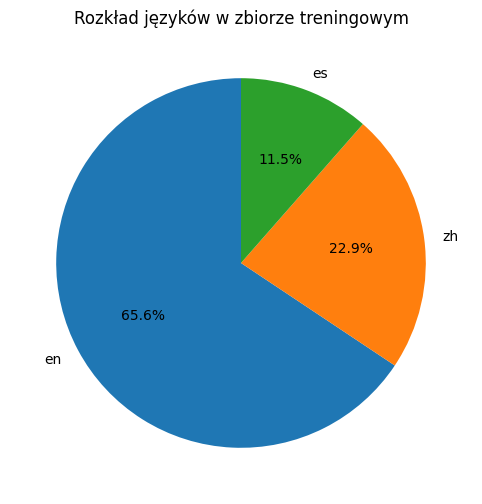

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
language_stats = train_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze treningowym')

plt.savefig('images/language_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

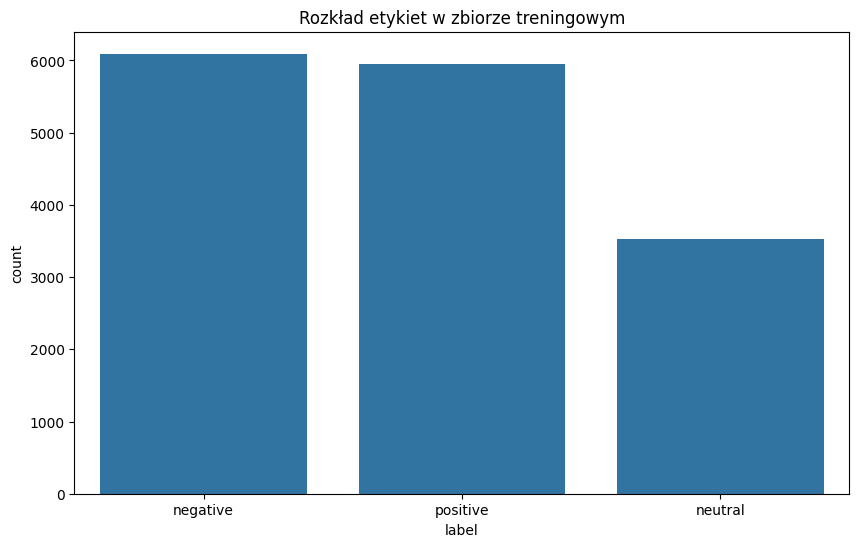

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
label_stats = train_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze treningowym')

plt.savefig('images/label_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

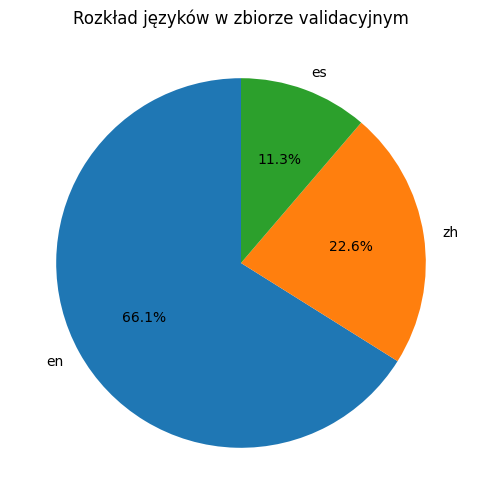

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
language_stats = eval_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze validacyjnym')

plt.savefig('images/language_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

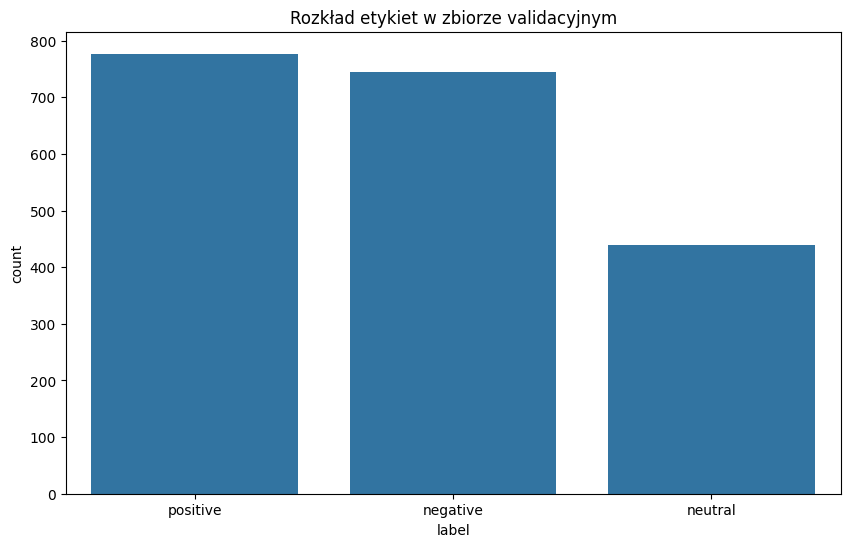

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
label_stats = eval_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze validacyjnym')

plt.savefig('images/label_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

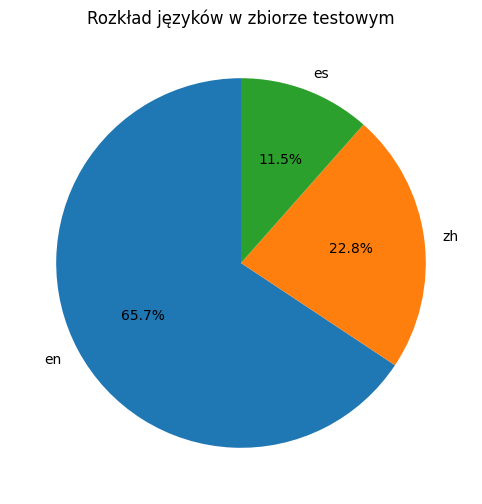

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
language_stats = test_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze testowym')

plt.savefig('images/language_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

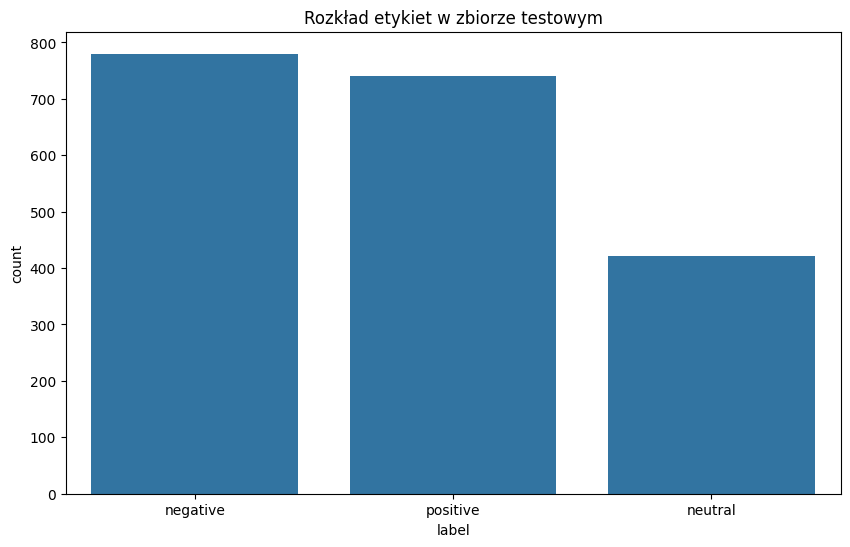

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
label_stats = test_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze testowym')

plt.savefig('images/label_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

### Tokenizacja

W ramach tego etapu załadowaliśmy juz wstępnie wytrenowany model i tokenizator z bert-base-multilingual-cased i dokonaliśmy tokenizacji zbioru treningowego i validacyjnego

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

def tokenize_and_encode(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # BERT max sequence length
        # return_tensors=None,  # Returns PyTorch tensors
        # return_special_tokens_mask=True
    )



tokenized_train_ds = train_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_train_ds = tokenized_train_ds.rename_column("label_id", "label")
tokenized_eval_ds = eval_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_eval_ds = tokenized_eval_ds.rename_column("label_id", "label")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
print(tokenized_train_ds[0])

{'label': 2, 'input_ids': [101, 3767, 3392, 5605, 10064, 5286, 7520, 1882, 1882, 1882, 131, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Trening

W ramach treningu dodaliśmy własną funkcję compute_metrics, która ma na celu obliczanie accuracy oraz f1 po validacji kazdej z epok

In [48]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

model.to('cpu')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir="./multilingual_bert_sentiment",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("./multilingual_bert_sentiment")
trainer.evaluate()

/var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/ipykernel_34965/1482221042.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 